In [2]:
# Random data generator for testing the neural network

import random

def generate_data(num_entries, num_rows, filename):
    # Open the file for writing
    with open(filename, 'w') as file:
        # Generate each row
        for i in range(num_rows):
            # Generate each entry in the row as a list of 3 integers following a simple pattern
            row = [
                f"[{random.randint(1, 69)}, {random.randint(5, 80)}]"
                for _ in range(num_entries)
            ]
            print(row)
            # Join all entries into a single string with commas and write to file
            formatted_row = ', '.join(row)
            file.write(f"\"{formatted_row}\"\n")

# Example usage:
generate_data(20, 30, 'fake_data.csv')

['[43, 14]', '[11, 11]', '[67, 10]', '[38, 46]', '[9, 38]', '[11, 20]', '[2, 28]', '[35, 75]', '[6, 71]', '[67, 12]', '[43, 25]', '[27, 7]', '[33, 57]', '[54, 56]', '[54, 31]', '[22, 68]', '[23, 16]', '[26, 77]', '[29, 69]', '[3, 76]']
['[27, 34]', '[57, 79]', '[66, 25]', '[61, 34]', '[65, 63]', '[11, 27]', '[47, 47]', '[60, 29]', '[10, 79]', '[60, 18]', '[6, 10]', '[48, 19]', '[38, 22]', '[43, 52]', '[32, 26]', '[15, 16]', '[44, 30]', '[11, 24]', '[47, 26]', '[15, 35]']
['[61, 63]', '[21, 66]', '[15, 13]', '[61, 18]', '[68, 50]', '[54, 58]', '[42, 49]', '[5, 51]', '[66, 47]', '[58, 9]', '[21, 25]', '[18, 18]', '[21, 43]', '[45, 35]', '[30, 49]', '[4, 79]', '[43, 79]', '[20, 14]', '[11, 52]', '[68, 49]']
['[61, 64]', '[45, 16]', '[59, 58]', '[8, 54]', '[26, 76]', '[38, 9]', '[42, 33]', '[51, 7]', '[51, 68]', '[56, 43]', '[57, 32]', '[50, 78]', '[35, 16]', '[19, 5]', '[32, 67]', '[41, 45]', '[11, 44]', '[19, 27]', '[1, 70]', '[26, 69]']
['[66, 12]', '[35, 65]', '[13, 38]', '[43, 43]', '

In [1]:
# Import necessary function
# When changing the duration for testing, remember to delete previous data


import EVERYTHING_experiment as experiment
import random
import time

rabbit_range = (2, 100)
fox_range = (2, 100)

def generate_data(duration, num_rows, filename, num_rabbits, num_foxes):
    # Open the file for writing

        # Generate each row using the generate() function
        for i in range(num_rows):
            num_rabbits = random.randint(rabbit_range[0], rabbit_range[1])
            num_foxes = random.randint(fox_range[0], fox_range[1])
            try:
                with open(filename, 'a') as file:
                    # Generate the row as a list of tuples
                    sim_start = time.time()
                    row = experiment.run_simulation(num_rabbits, num_foxes, duration)
                    sim_end = time.time()
                    # Format each tuple into a string "[x, y]"
                    formatted_row = [f"[{x}, {y}]" for x, y in row]
                    # Join all entries into a single string with commas and write to file
                    formatted_row_str = ', '.join(formatted_row)
                    file.write(f"\"{formatted_row_str}\"\n")

                    total_estimated_time = (sim_end - sim_start) * (num_rows - i) 
                    print(f"Progress: {i}th run. Estimated time left: {total_estimated_time/60:.2f} minutes")
            except:
                print("Error with this simulation!")

generate_data(200, 500, 'final_data.csv', 20, 3)

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


Time: 100
Time: 200
[(56, 37), (51, 37), (51, 37), (51, 37), (51, 37), (50, 37), (50, 37), (50, 37), (50, 37), (50, 37), (50, 37), (50, 37), (50, 37), (49, 37), (49, 37), (49, 37), (49, 37), (49, 37), (49, 37), (49, 37), (48, 37), (48, 37), (48, 37), (47, 38), (47, 38), (47, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (46, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (43, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (42, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (41, 38), (40, 38), (40, 38), (40, 38), (40, 38), (40, 38), (40, 38), (40, 38), (40, 38), (40, 38),

In [ ]:
import numpy as np
import pandas as pd
import ast

# Load and parse the CSV data
def load_and_parse_data(file_path):
    data = pd.read_csv(file_path, header=None)
    sequences = []
    for index, row in data.iterrows():
        # Convert the row from string representation to list of lists of integers
        sequence = ast.literal_eval(row[0])
        sequences.append(sequence)
    return np.array(sequences)

# Split sequences into input and target
def split_sequences(sequences):
    discard_counter = 0

    inputs = []
    targets = []
    for seq in sequences:
        if len(seq) >= 5000:
            seq = seq[:5000]
            print(len(seq))
            mid = len(seq) // 2
            inputs.append(seq[:mid])
            targets.append(seq[mid:])
        return np.array(inputs), np.array(targets)
    else:
        discard_counter +=1
        print(f"Discarded {discard_counter} sequences")

# Load and preprocess the data
file_path = 'fake_data.csv'  # replace with your file path
sequences = load_and_parse_data(file_path)
inputs, targets = split_sequences(sequences)

print(inputs)
print(targets)



20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
[[[60 48]
  [17 43]
  [46 70]
  [31 56]
  [66 55]
  [16 54]
  [58 17]
  [20 49]
  [64  8]
  [ 5 63]]

 [[18 48]
  [56  5]
  [20 12]
  [65 14]
  [29 35]
  [ 9 53]
  [66 80]
  [30 41]
  [39 57]
  [60 71]]

 [[51 30]
  [52 70]
  [46 51]
  [ 7 45]
  [59 11]
  [31 69]
  [13 14]
  [62 66]
  [30  9]
  [48 16]]

 [[15 19]
  [60 70]
  [39 58]
  [42 31]
  [64 12]
  [18 10]
  [38 78]
  [52 36]
  [21 29]
  [49 27]]

 [[62 62]
  [33  6]
  [66 48]
  [53 20]
  [58 71]
  [58  9]
  [20 19]
  [40 42]
  [62 42]
  [25 57]]

 [[18 46]
  [34 76]
  [58 21]
  [53 38]
  [62 80]
  [55 69]
  [68 25]
  [ 7 41]
  [32 14]
  [46 29]]

 [[30 26]
  [14 67]
  [20 41]
  [ 6 41]
  [37 43]
  [62 78]
  [48 45]
  [42 77]
  [57 26]
  [28 23]]

 [[45 48]
  [34 18]
  [11 52]
  [ 3 11]
  [69 22]
  [10 24]
  [65 36]
  [17 40]
  [10 23]
  [ 5 80]]

 [[17 64]
  [59 73]
  [42 40]
  [47 71]
  [58 67]
  [43 41]
  [19 16]
  [50 20]
  [45 75]
  [6

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the Data
input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from keras.regularizers import l2

# Defining constants we are going to use
n_input = 100  # HALF OF THE WHOLE SEQUENCE LENGTH
n_output = 100  # HALF OF THE WHOLE SEQUENCE LENGTH
n_features = 2 # We can add grass or not

# Define the model
model = Sequential()

# Encoder part
model.add(LSTM(150, activation='tanh', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.2))

# Another LSTM layer
model.add(LSTM(100, activation='tanh', return_sequences=False))

# RepeatVector is used as a bridge between the encoder and decoder parts
model.add(RepeatVector(n_output))


# Decoder part
model.add(LSTM(150, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=True))

# Densely connected output layer
model.add(TimeDistributed(Dense(n_features)))

# Compiling the model
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
model.fit(input_train, target_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5


ValueError: in user code:

    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\wasil\anaconda3\envs\ml01\lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 500 and 501 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_1/time_distributed_1/Reshape_1, mean_squared_error/Cast)' with input shapes: [?,500,2], [?,501,2].


In [ ]:
loss = model.evaluate(input_test, target_test, verbose=0)
print('Model loss:', loss)

Model loss: 1318694.375


1/1 [==============================] - 1s 1s/step


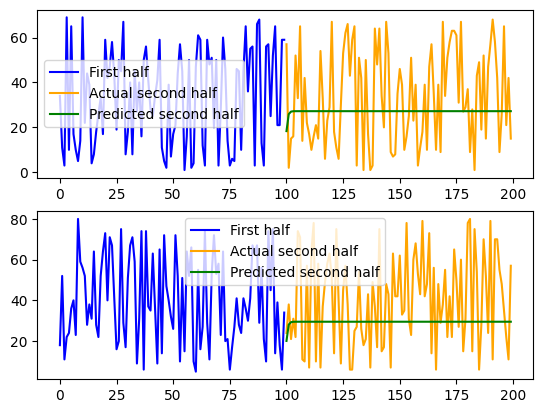

In [ ]:
import matplotlib.pyplot as plt
import random

# pick a random index from the test dataset
idx = random.randint(0, len(input_test) - 1)

# get the corresponding sequences
input_seq = input_test[idx]
target_seq = target_test[idx]

# reshape the input sequence and make a prediction
predicted_seq = model.predict(input_seq.reshape(1, n_input, n_features))[0]

# create two subplots, one for each variable
fig, axs = plt.subplots(2)

# use different colors for the first half, actual second half and predicted second half
colors = ['blue', 'orange', 'green']

for i in range(2):
    # plot the first half of the sequence
    axs[i].plot(range(0, n_input), input_seq[:, i], color=colors[0], label='First half')
    # plot the second half of the sequence
    axs[i].plot(range(n_input, 2*n_input), target_seq[:, i], color=colors[1], label='Actual second half')
    # plot the model's prediction for the second half of the sequence
    axs[i].plot(range(n_input, 2*n_input), predicted_seq[:, i], color=colors[2], label='Predicted second half')
    axs[i].legend()

plt.show()

1/1 [==============================] - 0s 81ms/step


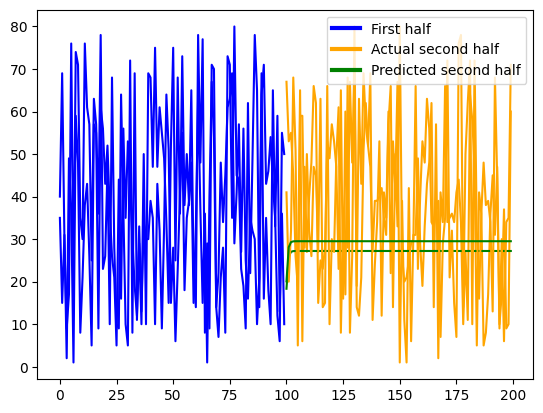

In [ ]:
from matplotlib.lines import Line2D

# Assuming input_test and target_test are correctly shaped as (num_samples, n_input, n_features)
# Pick a random index from the test dataset
idx = random.randint(0, len(input_test) - 1)

# Get the corresponding sequences
input_seq = input_test[idx]
target_seq = target_test[idx]

# Reshape the input sequence for prediction if necessary
if input_seq.ndim < 3:
    input_seq = input_seq.reshape(1, n_input, n_features)

# Make a prediction
predicted_seq = model.predict(input_seq)[0]

# Create a plot
fig, ax = plt.subplots()

# Use different colors for the first half, actual second half, and predicted second half
colors = ['blue', 'orange', 'green']

# Plot the first half of the sequence, the second half of the sequence, and the prediction
for i in range(2):  # Only predict 2 variables
    ax.plot(range(0, n_input), input_seq[0, :, i], color=colors[0])
    ax.plot(range(n_input, 2*n_input), target_seq[:, i], color=colors[1])
    ax.plot(range(n_input, 2*n_input), predicted_seq[:, i], color=colors[2])

# Set up legend
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['First half', 'Actual second half', 'Predicted second half']
ax.legend(lines, labels)

plt.show()